<h1 align='center'> Stainless Steel Welding Type Classification </h3>

<p> The General idea of this notebook is to highlight all the process and subprocesses done for Stainless Steel Welding Type Classification.<br>For this project we have used the dataset provided <a href="https://www.kaggle.com/code/kerneler/starter-tig-stainless-steel-304-ee6df282-0/data">Here</a>. </p>

<h4> <u> Dataset Discussion </u> </h4>
<div>
    <img src='Assets/Dataset_Labels.png' align='right' width=600 height=300>
    <p align='left'><br>Our Dataset has been label encoded as following: <br> The idea is that provided an image our classifier will be able to classify the results as one of the following labels. <br><br>["good weld","burn through","contamination","lack of fusion","lack of shielding gas","high travel speed"]<br><br>
    Since we are following supervised approach we have a json file which maps each image with corresponding output labels which can be used to map each image with corresponding labels.
</div>
 <br><br><br> The mentioned json file can be seen below: <br> <br></p>
<img src='Assets/json_files.png' width=550><br>
Finally the project working directory should be something like this: <br>
<br>
<img src='Assets/Project_Structure.png'>
<h2> 0. Intalling Dependencies </h2>

In [ ]:
!pip install -r requirements

<h2> 1. Importing Dependencies </h2>

Let's import all the dependencies so we can use it later

In [1]:
import json
import numpy as np 
from PIL import Image
import tensorflow as tf
import os
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt
import sys
from keras import backend as K
from sklearn.utils import class_weight

np.set_printoptions(threshold=sys.maxsize)

<h2> 2. PreProcessing </h2>

<p> Once Downloaded please unzip the dataset on the same working directory and the folder directory should be: <br>

<i>../ss304/train/train.json</i>
</p>

<br>

<p> The steps invovled in the preprocessing steps are: <br>
    <ol>
        <li> Getting path of json as input train.json for train dataset and test.json for test dataset </li>
        <li> Getting images path from jsons </li>
        <li> Opening image and resizing them to 200x200 dimensions </li>
        <li> Converting the resized image to numpy array </li>
        <li> Combing all individual images array to one huge array X for training and X test for testing </li>
        <li> Getting all the labels from jsons and converting into one huge array Y for training and Y test for testing </li>
    </ol>
    <br> These steps can be visualized from the image below: 
    <img src='Assets/preprocessing_under_hood.png'>
    <br>
    Note: This cell will take a bit of time to run because its doing alot of computations at once.
</p>



In [2]:
def convert_to_array(i,features,f):

    if f==0:
        image=features[i]
        
    else: 
        image=i
    
    image = Image.open(image)
    if f==1:
        plt.imshow(image,cmap='gray')
    image=image.resize((200,200))
    numpydata = np.asarray(image)
    numpydata = numpydata.astype('float32')

    # Normalize to the range 0-1
    numpydata /= 255.0
    return numpydata


def get_images_array_and_labels(path):
    print('Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed')
    with open(path,'r') as datasets:
        datasets=json.load(datasets)
    features=list(datasets.keys())
    features=['/'.join(path.split('\\')[0:-1])+'/'+str(i) for i in features]
    features=np.array([convert_to_array(i,features,0) for i in range(len(features))])
    labels=np.array(list(datasets.values())).reshape(-1,1)
    return features,labels
    
    

X,Y=get_images_array_and_labels('ss304\\train\\train.json')
Xtest,Ytest=get_images_array_and_labels('ss304\\test\\test.json')



Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed
Getting all the images, Resizing it and converting it to numpy array so that it can be fitted on CNN. It might take some time depending upon processing speed


<h3> Handling Imablanced Dataset </h3>

The dataset provided to us is extremely imbalanced with most cases being for good weld this can result in poor tracking of updates so we are extracting 
classweights these are basically pentality assocaited with each class being detected so if a minority class is being wrongly classified it has high penalty then then majority class being wrongly classified and viceversa for accuracy too.


In [3]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',  classes=np.unique(Y), y=np.squeeze(Y))
class_weights=list(class_weights)
class_weights = dict(zip(np.unique(Y), class_weights))
print(class_weights)


{0: 0.25609446419502285, 1: 4.1289662231320365, 2: 2.5009299442033477, 3: 0.801032565528197, 4: 20.581632653061224, 5: 6.4031746031746035}


<h2> 3. Building our Convolutional Nerual Network </h2>

<p> The overall architecture of the entire CNN designed is provided below </p>

<img src='Assets/CNN Architecture.png'>

The image above can be interpreted as: 
<ul>
    <li> Feed input array to the CNN </li>
    <li> The first convlution layer has 32 filters with it </li>
    <li> The output of first convlution is reduced with maxpooling </li>
    <li>Second convlution layer is carried out with 64 filters with it </li>
    <li> The output of second convlution layer is again reduced with maxpooling </li>
    <li> Similarly we do 3 other covolutions and max poolinig with 128 , 256 filters and 512 filters </li>
    <li>Flatten the final output from convlution portion </li>
    <li> The Flattened one d array is connected to a fully connected layer with 64 neurons on first layer 32 neurons on second layer,16 layers on third layer  and 6 outputs on final layer </li>
</ul>

This cell also has some utilities functions with the model creation portions 


In [32]:
def write_training_history(history):
    with open('training_checkpoints.json','w') as f:
            json.dump(history,f)

def load_training_history():
    with open('training_checkpoints.json','r') as f:
            f=json.load(f)
    return f


def get_updated_history(history):
    
    if 'training_checkpoints.json' not in os.listdir(os.getcwd()):
        write_training_history(history)
    else: 
        f=load_training_history()
        f['loss']=f['loss']+history['loss']
        f['precision_avg']=f['precision_avg']+history['precision_avg']
        f['recall_avg']=f['recall_avg']+history['recall_avg']
        f['f1_avg']=f['f1_avg']+history['f1_avg']

        f['val_loss']=f['val_loss']+history['val_loss']
        f['val_precision_avg']=f['val_precision_avg']+history['val_precision_avg']
        f['val_recall_avg']=f['val_recall_avg']+history['val_recall_avg']
        f['val_f1_avg']=f['val_f1_avg']+history['val_f1_avg']
        write_training_history(f)
    
    return load_training_history()

def load_previous_model(CNN_model):
    if 'Stainless_Steel_Classification_model.h5' in os.listdir(os.getcwd()):
        CNN_model=tf.keras.models.load_model('Stainless_Steel_Classification_model.h5',custom_objects={"recall_avg": recall_avg,'precision_avg':precision_avg,'f1_avg':f1_avg})
    else: 
         if 'training_checkpoints.json' in os.listdir(os.getcwd()):
             os.remove('training_checkpoints.json') 
    
    return CNN_model

def recall(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    possible_postives = K.sum(true_c)
    return true_positives / (possible_postives + K.epsilon())


def precision(y_true, y_pred, c):
    y_true = K.flatten(y_true)
    pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
    true_c = K.cast(K.equal(y_true, c), K.floatx())
    true_positives = K.sum(pred_c * true_c)
    pred_positives = K.sum(pred_c)
    return true_positives / (pred_positives + K.epsilon())

def recall_avg(y_true,y_pred):
    recall_avg=0
    for i in range(0,6):
        recall_avg+=recall(y_true,y_pred,i)
    recall_avg=recall_avg/6
    return recall_avg

def precision_avg(y_true,y_pred):
    precision_avg=0
    for i in range(0,6):
        precision_avg+=precision(y_true,y_pred,i)
    precision_avg=precision_avg/6
    return precision_avg

def f1_avg(y_true,y_pred):
    return 2*(precision_avg(y_true,y_pred)*recall_avg(y_true,y_pred))/(precision_avg(y_true,y_pred)+recall_avg(y_true,y_pred))

def plot_metrics_for_training(history):
    
    plt.figure(figsize=(25, 10))
    plt.subplot(221)
    plt.plot(history['precision_avg'], label='precision_avg')
    plt.plot(history['val_precision_avg'], label = 'val_precision_avg')
    plt.xticks(np.arange(len(history['precision_avg'])), np.arange(1, len(history['precision_avg'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Precision_avg')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='lower right')

    plt.subplot(222)
    plt.plot(history['recall_avg'], label='recall_avg')
    plt.plot(history['val_recall_avg'], label = 'val_recall_avg')
    plt.xticks(np.arange(len(history['recall_avg'])), np.arange(1, len(history['recall_avg'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('Recall_avg')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='upper center')

    plt.subplot(223)
    plt.plot(history['f1_avg'], label='f1_avg')
    plt.plot(history['val_f1_avg'], label = 'val_f1_avg')
    plt.xticks(np.arange(len(history['f1_avg'])), np.arange(1, len(history['f1_avg'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('F1_Avg')
    plt.ylim([0.001, 1.05])
    plt.legend(loc='upper center')

    plt.subplot(224)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label = 'val_loss')
    plt.xticks(np.arange(len(history['loss'])), np.arange(1, len(history['loss'])+1))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([0.001, 2.0])
    plt.legend(loc='upper center')
    
    plt.savefig('output_details.png')


def create_cnn_model():
    model=tf.keras.models.Sequential()

    #Convlution Process Starts here.
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(200,200, 1)))
    model.add(tf.keras.layers.MaxPool2D((2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    model.add(tf.keras.layers.Conv2D(512,(3,3),activation='relu'))
    model.add(tf.keras.layers.MaxPool2D((2,2)))

    #Fully Connected Layer from here 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.0005)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(16,activation='relu'))
    
    model.add(tf.keras.layers.Dense(6,activation='softmax',kernel_regularizer=tf.keras.regularizers.L2(l2=0.0005))) 
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    #opt=tf.keras.optimizers.RMSprop(learning_rate=0.001)

    #Compile the CNN Model
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[recall_avg,precision_avg,f1_avg])
    model.summary()
    return model
    
number_of_epochs=30
CNN_model=create_cnn_model()
callback = tf.keras.callbacks.EarlyStopping(patience=int(number_of_epochs/4), monitor='val_f1_avg',mode='max',restore_best_weights=True )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 23, 23, 128)     

<h2> 4. Training CNN Model </h2> 
<p> The steps invovled for training the blank model created earlier is shown  below: </p>
<img src='Assets/training Architecture.png'><br>
From the Image above we can interpret that: 
<ul>
    <li> Initially we get the blank model built from previous cell </li><br>
    <li> Then we check the working directory for model file if present or not </li><br>
    <li> If model file is present then: 
        <ul>
            <li>    We load its weights to blank model and history  </li>
        </ul>
    </li><br>
    <li> We train the blank model (loaded with weights or random weights depends on previous step) </li><br>
    <li> Once training completed we save the history (combined with previous history or not) and current model on working directory </li>

In [33]:
CNN_model=load_previous_model(CNN_model)
history_for_plotting=CNN_model.fit(X,Y,epochs=number_of_epochs,batch_size=256,validation_data=(Xtest,Ytest),shuffle=True,callbacks=[callback],class_weight=class_weights)
history_for_plotting=get_updated_history(history_for_plotting.history)
CNN_model.save('Stainless_Steel_Classification_model.h5')


Epoch 1/30
95/95 [==============================] - 385s 4s/step - loss: 0.2417 - recall_avg: 0.9196 - precision_avg: 0.7694 - f1_avg: 0.8365 - val_loss: 0.2198 - val_recall_avg: 0.9227 - val_precision_avg: 0.8681 - val_f1_avg: 0.8941
Epoch 2/30
95/95 [==============================] - 379s 4s/step - loss: 0.2011 - recall_avg: 0.9400 - precision_avg: 0.8103 - f1_avg: 0.8690 - val_loss: 0.2285 - val_recall_avg: 0.8840 - val_precision_avg: 0.8570 - val_f1_avg: 0.8697
Epoch 3/30
95/95 [==============================] - 377s 4s/step - loss: 0.2170 - recall_avg: 0.9350 - precision_avg: 0.8092 - f1_avg: 0.8663 - val_loss: 0.3023 - val_recall_avg: 0.8795 - val_precision_avg: 0.8323 - val_f1_avg: 0.8546
Epoch 4/30
95/95 [==============================] - 397s 4s/step - loss: 0.1543 - recall_avg: 0.9513 - precision_avg: 0.8526 - f1_avg: 0.8984 - val_loss: 0.3881 - val_recall_avg: 0.8638 - val_precision_avg: 0.7776 - val_f1_avg: 0.8177
Epoch 5/30
95/95 [==============================] - 390s 4s/

<h2> 5. Visualizing the performance of the model </h2>
<p> For Visualization of the project we have followed the process as: </p>
<img src='Assets/Visualizing Results.png' align='left'><p align='right'> From the figure we can understand that we first load the history file which is present in json format<br><br> That same file has details in complicated format we convert it into a format that can be understood by us and is displayed on the screen <br><br>  Finally the interpretable output is plotted in the form of graph to visually see how the model works on data </p>

349/349 [==============================] - 34s 97ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7628
           1       1.00      1.00      1.00       731
           2       0.99      0.95      0.97       960
           3       0.94      0.89      0.91      1490
           4       0.33      0.84      0.47       102
           5       0.98      1.00      0.99       249

    accuracy                           0.97     11160
   macro avg       0.87      0.94      0.89     11160
weighted avg       0.98      0.97      0.97     11160



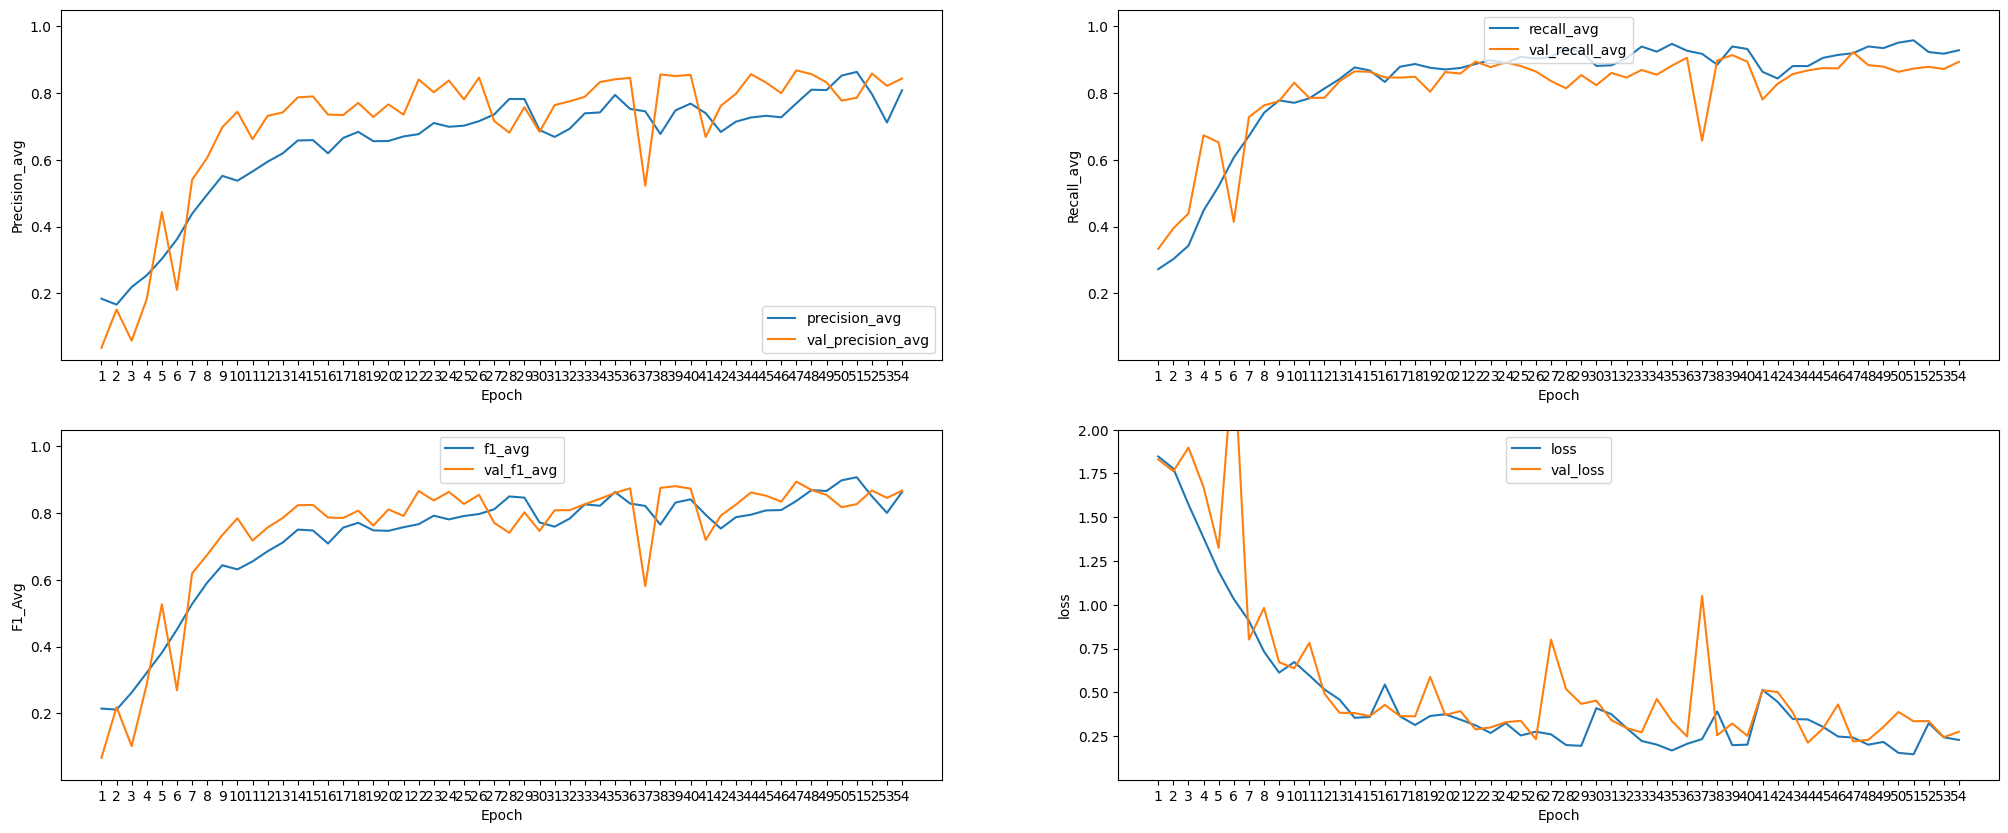

In [34]:
history_for_plotting=load_training_history()
plot_metrics_for_training(history_for_plotting)
CNN_model=load_previous_model(CNN_model)
Yverify=CNN_model.predict(Xtest)
Yverify=np.argmax(Yverify,axis=1).reshape(-1,1)
op=classification_report(Ytest,Yverify)
print(op)

<h2> 6.Inference Testing </h2>

Now that we have completed the training and also have the final results, How do we use the model ? This process can be understood as follows: 
<br><img src='Assets/Inference Architecture.png'><br>
We should focus on using all the files inside the folder verify for inference testing 
Here While Inference testing try following: 
<ul>
    <li> input= ss304/train/160705-114214-50mmLens w.s.75cm.m/image-0001.png    should give output   5 and high travel speed    </li>
    <li> input= ss304/test/160705-121434-50mmLens added slug/image-0001.png     should give output   2 and contamination        </li>
    <li> input= ss304/valid/160705-114925-50mmLens w.s.16cm.m/image-0150.png    should give output   0 and good weld            </li>
    <li> input= ss304/test/160708-145105-50mmLens 350A w.s.Lev16 g.f.20L.m try joining 10mm Plate/image-0042.png    should give output  3 and Lack of Fusion </li>
    <li> input= ss304/valid/161215-093333-run9/image-0278.png   should give output      1, burn through </li>
    <li> input= ss304/test/160707-111307-50mmLens 200A w.s.11.5cm.m + no shielding gas/image-0219.png    should give output      4, lack of sheilding glass </li>

Input image: ss304/test/160707-111307-50mmLens 200A w.s.11.5cm.m + no shielding gas/image-0219.png
1/1 [==============================] - 0s 76ms/step
[[2.0078426e-04 1.1710703e-04 1.0683930e-04 1.0482926e-03 9.9852604e-01
  8.9886913e-07]]
output obtained: 4
Final output: lack of shielding gas


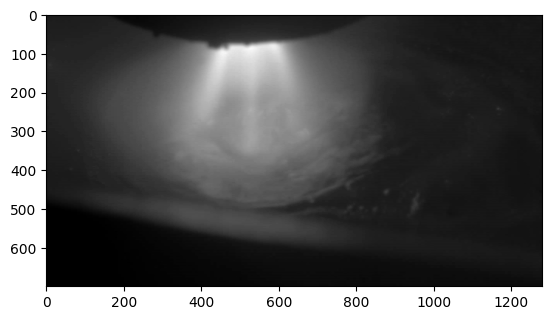

In [31]:
#var1='ss304/train/160705-114214-50mmLens w.s.75cm.m/image-0001.png' #op=5,high travel speed
#var2='ss304/test/160705-121434-50mmLens added slug/image-0001.png'  #op=2,contaimination
#var3='ss304/valid/160705-114925-50mmLens w.s.16cm.m/image-0150.png' #op=0,good weld 
#var4='ss304/test/160708-145105-50mmLens 350A w.s.Lev16 g.f.20L.m try joining 10mm Plate/image-0042.png' #op=3, lack of fusion
#var5='ss304/valid/161215-093333-run9/image-0278.png' #op=1, burn through
#var6='ss304/test/160707-111307-50mmLens 200A w.s.11.5cm.m + no shielding gas/image-0219.png #op4,lack of sheilding glass

CNN_model=load_previous_model(CNN_model)
var_input=input('Enter path of the image to test: ')
print(f'Input image: {var_input}')
op_list=["good weld","burn through","contamination","lack of fusion","lack of shielding gas","high travel speed"]
test_image=convert_to_array(var_input,[],1)
prediction=CNN_model.predict(test_image.reshape(1,200,200,1))
print(prediction)
prediction=np.argmax(prediction)
print(f'output obtained: {prediction}')
print(f'Final output: {op_list[prediction]}')